In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

Membaca dataset CSV

In [5]:
print("Loading data...")
df = pd.read_csv("midterm-regresi-dataset.csv", header=None)
print(f"Original shape: {df.shape}")

df.head()

Loading data...
Original shape: (515345, 91)


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Cleaning Dataset

In [9]:
# Drop baris yang semua nilainya NaN
df = df.dropna(how='all')
df = df.drop_duplicates()
print(f"After cleaning shape: {df.shape}")

After cleaning shape: (515131, 91)


Memisahkan fitur dan target

In [10]:
target_col = 0  # kolom pertama adalah tahun
y = df[target_col]
X = df.drop(columns=[target_col])

print(f"Features shape: {X.shape}")
print(f"Target range: {y.min()} - {y.max()}")
print(f"Target mean: {y.mean():.2f}, std: {y.std():.2f}")

Features shape: (515131, 90)
Target range: 1922 - 2011
Target mean: 1998.40, std: 10.93


Visualisasi data
- Distribusi target - melihat sebaran tahun
- Missing values per fitur - identifikasi data hilang
- Korelasi dengan target - melihat hubungan fitur dengan target

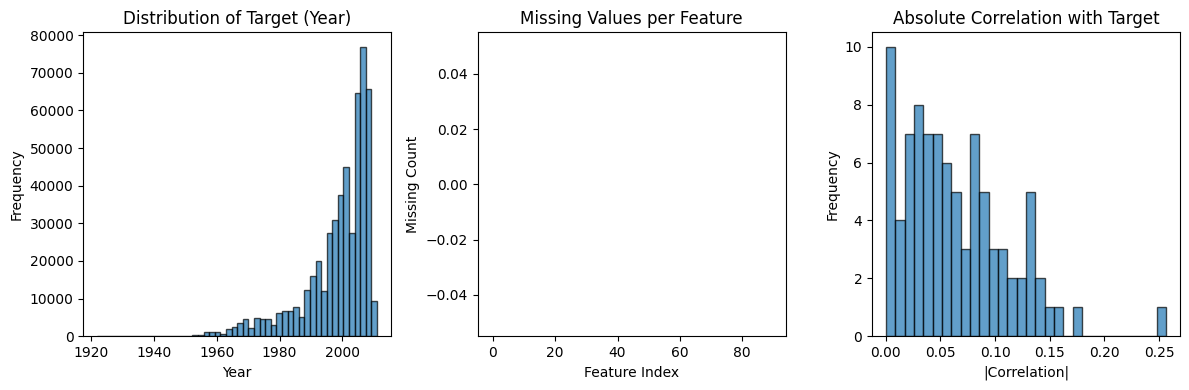

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(y, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Target (Year)')
plt.xlabel('Year')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
# Cek missing values per kolom
missing_values = X.isnull().sum()
plt.bar(range(len(missing_values)), missing_values.values)
plt.title('Missing Values per Feature')
plt.xlabel('Feature Index')
plt.ylabel('Missing Count')

plt.subplot(1, 3, 3)
# Korelasi fitur dengan target (sample untuk efisiensi)
sample_idx = np.random.choice(X.shape[0], size=min(1000, X.shape[0]), replace=False)
correlations = []
for col in range(X.shape[1]):
    corr = np.corrcoef(X.iloc[sample_idx, col], y.iloc[sample_idx])[0, 1]
    correlations.append(abs(corr))

plt.hist(correlations, bins=30, edgecolor='black', alpha=0.7)
plt.title('Absolute Correlation with Target')
plt.xlabel('|Correlation|')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Preprocessing data
- Split data menjadi 80% training 20% testing
- mengisi nilai kosong dengan median 
- normalisasi fitur ke skala standar

In [13]:
print("\nPreprocessing data...")

# Train-test split dulu untuk menghindari data leakage
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Imputasi missing values
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed = imputer.transform(X_test_raw)

# Scaling fitur
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_imputed)
X_test_scaled = scaler_X.transform(X_test_imputed)

# Normalisasi target juga (penting untuk deep learning)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).flatten()

# Simpan versi tidak dinormalisasi untuk evaluasi
y_train_np = y_train_raw.values.astype(np.float32)
y_test_np = y_test_raw.values.astype(np.float32)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")



Preprocessing data...
Training set: (412104, 90)
Test set: (103027, 90)


training dataset dengan batch size 356

In [17]:
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Gunakan target yang sudah dinormalisasi untuk training DL
train_dataset = RegressionDataset(X_train_scaled, y_train_scaled)
test_dataset = RegressionDataset(X_test_scaled, y_test_scaled)

# Batch size lebih kecil
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout=0.2):
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [19]:
# Setup training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = X_train_scaled.shape[1]
model = SimpleMLP(input_dim, hidden_dims=[128, 64, 32], dropout=0.3).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

Using device: cpu


proses training 
- Training phase - forward pass, loss computation, backward pass
- Validation phase - evaluasi tanpa gradient computation
- Early stopping - menghentikan training jika tidak membaik
- Logging - mencatat loss, R² score, dll.

In [ ]:
num_epochs = 100
train_losses = []
val_losses = []
val_r2_scores = []  # Tambah tracking R²
learning_rates = []  # Track perubahan learning rate

best_val_loss = float('inf')
best_val_r2 = -float('inf')
patience = 10
patience_counter = 0

print(f"\nStarting training for {num_epochs} epochs...")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Total batches per epoch: {len(train_loader)}")
print("-" * 80)

for epoch in range(num_epochs):
    # Phase 1: TRAINING
    model.train()
    epoch_train_loss = 0.0
    batch_counter = 0
    
    # Training dengan progress bar sederhana
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping untuk stabilitas
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        batch_size_current = X_batch.size(0)
        epoch_train_loss += loss.item() * batch_size_current
        batch_counter += batch_size_current
        
        # Print batch progress setiap 100 batch
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx + 1:4d}/{len(train_loader):4d} | "
                  f"Batch Loss: {loss.item():.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Calculate average training loss
    avg_train_loss = epoch_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)
    
    # Phase 2: VALIDATION
    model.eval()
    epoch_val_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            epoch_val_loss += loss.item() * X_batch.size(0)
            
            # Simpan prediksi dan target untuk hitung R²
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    # Calculate validation metrics
    avg_val_loss = epoch_val_loss / len(test_dataset)
    val_losses.append(avg_val_loss)
    
    # Concatenate semua prediksi dan target
    all_predictions = np.vstack(all_predictions).flatten()
    all_targets = np.vstack(all_targets).flatten()
    
    # Hitung R² score (skala normalized)
    val_r2 = r2_score(all_targets, all_predictions)
    val_r2_scores.append(val_r2)
    
    # Track learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Phase 3: LEARNING RATE SCHEDULER STEP
    scheduler.step(avg_val_loss)
    
    # Phase 4: EARLY STOPPING & MODEL CHECKPOINT
    # Gunakan kombinasi loss dan R² untuk menentukan model terbaik
    improvement_threshold = 0.0001
    
    if avg_val_loss < best_val_loss - improvement_threshold:
        best_val_loss = avg_val_loss
        best_val_r2 = val_r2
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_r2': val_r2,
        }, 'best_model_checkpoint.pth')
        
        model_improved = True
    else:
        patience_counter += 1
        model_improved = False
    
    # Phase 5: LOGGING & SUMMARY
    # Print summary setiap epoch
    if (epoch + 1) % 5 == 0 or epoch == 0 or model_improved or patience_counter >= patience:
        print(f"\n{'='*60}")
        print(f"EPOCH [{epoch+1:03d}/{num_epochs}] - SUMMARY")
        print(f"{'='*60}")
        
        # Training metrics
        print(f"TRAINING:")
        print(f"  • Loss: {avg_train_loss:.6f}")
        
        # Validation metrics
        print(f"VALIDATION:")
        print(f"  • Loss: {avg_val_loss:.6f} {'(IMPROVED!)' if model_improved else ''}")
        print(f"  • R² Score: {val_r2:.4f}")
        print(f"  • Best R² so far: {best_val_r2:.4f}")
        
        # Training dynamics
        print(f"TRAINING DYNAMICS:")
        print(f"  • Learning Rate: {current_lr:.6f}")
        print(f"  • Loss Reduction (Train→Val): {((avg_train_loss - avg_val_loss)/avg_train_loss*100):+.1f}%")
        
        if epoch > 0:
            train_loss_change = ((train_losses[-2] - avg_train_loss)/train_losses[-2]*100)
            val_loss_change = ((val_losses[-2] - avg_val_loss)/val_losses[-2]*100)
            print(f"  • Train Loss Δ: {train_loss_change:+.2f}%")
            print(f"  • Val Loss Δ:   {val_loss_change:+.2f}%")
        
        # Early stopping info
        print(f"EARLY STOPPING:")
        print(f"  • Patience Counter: {patience_counter}/{patience}")
        print(f"  • Best Val Loss: {best_val_loss:.6f}")
        
        # Gradient norms (opsional, untuk debugging)
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        print(f"  • Gradient Norm: {total_norm:.4f}")
        
        # Memory usage (jika menggunakan GPU)
        if torch.cuda.is_available():
            print(f"  • GPU Memory: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
    
    # Check early stopping
    if patience_counter >= patience:
        print(f"\n{'!'*60}")
        print(f"EARLY STOPPING TRIGGERED at epoch {epoch+1}")
        print(f"Reason: No improvement for {patience} consecutive epochs")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best validation R²: {best_val_r2:.4f}")
        print(f"{'!'*60}")
        break


Starting training for 100 epochs...
Training samples: 412104
Validation samples: 103027
Batch size: 256
Total batches per epoch: 1610
--------------------------------------------------------------------------------
  Batch  100/1610 | Batch Loss: 0.670968 | LR: 0.001000
  Batch  200/1610 | Batch Loss: 0.702275 | LR: 0.001000
  Batch  300/1610 | Batch Loss: 0.737616 | LR: 0.001000
  Batch  400/1610 | Batch Loss: 0.664334 | LR: 0.001000
  Batch  500/1610 | Batch Loss: 0.721631 | LR: 0.001000
  Batch  600/1610 | Batch Loss: 0.641341 | LR: 0.001000
  Batch  700/1610 | Batch Loss: 0.744804 | LR: 0.001000
  Batch  800/1610 | Batch Loss: 0.517975 | LR: 0.001000
  Batch  900/1610 | Batch Loss: 0.577308 | LR: 0.001000
  Batch 1000/1610 | Batch Loss: 0.563167 | LR: 0.001000
  Batch 1100/1610 | Batch Loss: 0.638575 | LR: 0.001000
  Batch 1200/1610 | Batch Loss: 0.758770 | LR: 0.001000
  Batch 1300/1610 | Batch Loss: 0.595253 | LR: 0.001000
  Batch 1400/1610 | Batch Loss: 0.514108 | LR: 0.001000


Evaluasi model dengan metrik MSE, MAE, R2 Score

In [24]:
model.eval()
y_pred_scaled = []
y_true_scaled = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_pred_scaled.append(outputs.cpu().numpy())
        y_true_scaled.append(y_batch.numpy())

y_pred_scaled = np.vstack(y_pred_scaled).reshape(-1)
y_true_scaled = np.vstack(y_true_scaled).reshape(-1)

# Transform back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_test_np

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


FINAL EVALUATION
MSE:  71.3777
RMSE: 8.4485
MAE:  5.8405
R²:   0.3935


Visualisasi

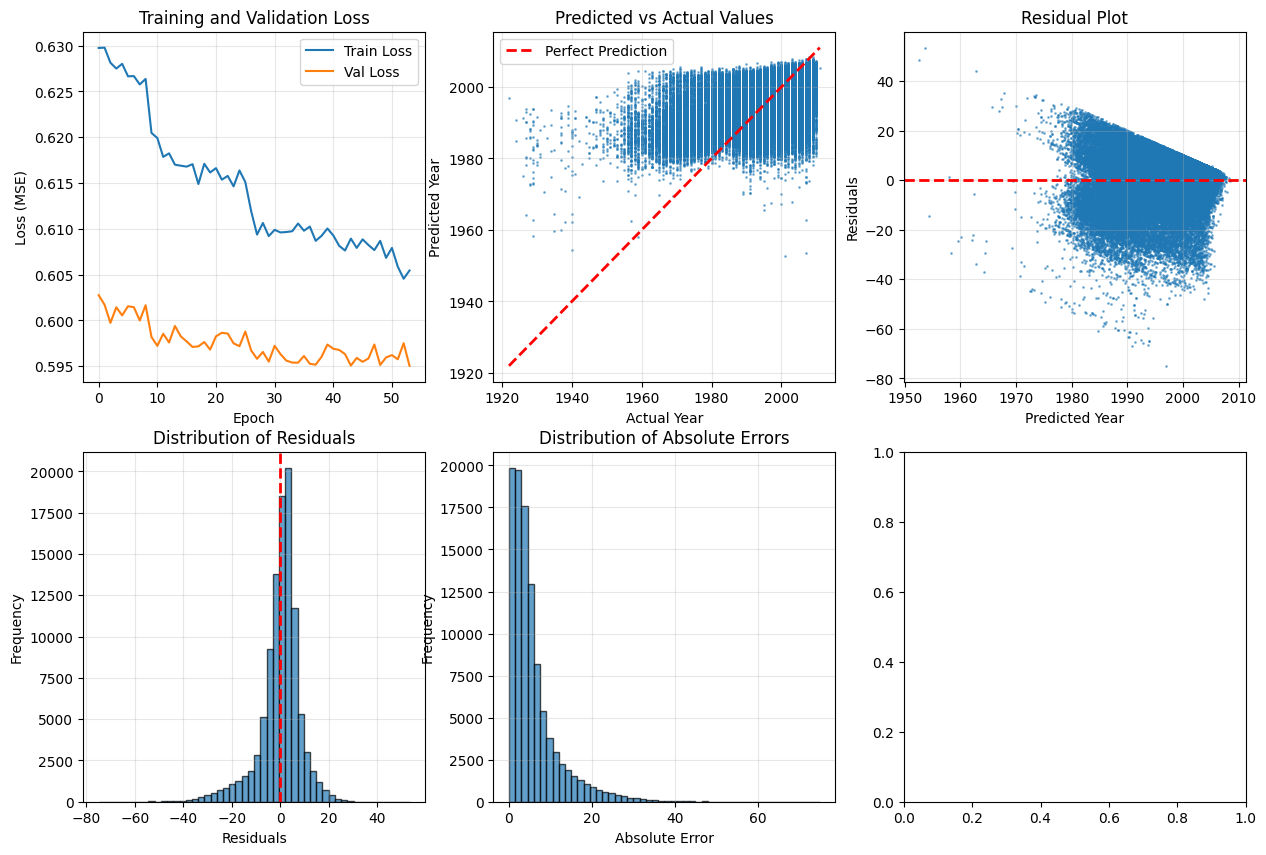

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Loss curve
axes[0, 0].plot(train_losses, label='Train Loss')
axes[0, 0].plot(val_losses, label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Prediction vs Actual (scatter)
axes[0, 1].scatter(y_true, y_pred, alpha=0.5, s=1)
axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Year')
axes[0, 1].set_ylabel('Predicted Year')
axes[0, 1].set_title('Predicted vs Actual Values')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residual plot
residuals = y_true - y_pred
axes[0, 2].scatter(y_pred, residuals, alpha=0.5, s=1)
axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Predicted Year')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('Residual Plot')
axes[0, 2].grid(True, alpha=0.3)

# Distribution of residuals
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].grid(True, alpha=0.3)

# Error distribution
error_abs = np.abs(residuals)
axes[1, 1].hist(error_abs, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Absolute Errors')
axes[1, 1].grid(True, alpha=0.3)
